In [3]:
import matplotlib.pyplot as plt
import re
import shutil
from nuimages import NuImages

In [4]:
nuim = NuImages(dataroot='/data/sets/nuimages', version='v1.0-mini', verbose=True, lazy=True)

Loading nuImages tables for version v1.0-mini...
Done loading in 0.000 seconds (lazy=True).


# Normalize function

In [5]:
# Annotate an image
limit = 10
IMG_WIDTH = 1600
IMG_HEIGHT = 900

class_mapper = {}

class_counter = 0

img_counter = 0

def normalize_bb(bb, img_width, img_height):
    bb[0], bb[2] = bb[0] / img_width, bb[2] / img_width
    bb[1], bb[3] = bb[1] / img_height, bb[3] / img_height

    return bb

def annotate_img(sample):
    global class_counter
    global img_counter
    # first retrieve its details
    detailed_sample = nuim.get('sample_data', sample['key_camera_token'])

    # then load the annotation
    object_tokens, _ = nuim.list_anns(sample['token'], verbose=False)
        
    # all the filename except the extension
    fname = detailed_sample['filename']
    shutil.copy(f'{cwd}/{fname}',
            f'/Users/hieuvuong/Desktop/datasets/images/img_{img_counter}.jpg')
    
    match = re.findall(r'_\w+', fname)
    with open(f'/Users/hieuvuong/Desktop/datasets/labels/img_{img_counter}.txt', 'w') as f:
        for token in object_tokens:
            annotation = nuim.get('object_ann', token)
            bbox = annotation['bbox']
            cat_token = annotation['category_token']
            class_name = nuim.get('category', cat_token)['name']
    
            if class_name not in class_mapper:
                class_mapper[class_name] = class_counter
                class_counter += 1
                    
            # normal bbox has type [class, xcenter, ycenter, width, height]
            bbox_width = bbox[2] - bbox[0]
            bbox_height = bbox[3] - bbox[1]
            center_x, center_y = (bbox[0] + bbox[2]) / 2, (bbox[3] + bbox[1]) /2
            
            # modify the bounding box to match YoloV5 format
            norm_bb = normalize_bb([center_x, center_y, bbox_width, bbox_height], IMG_WIDTH, IMG_HEIGHT)

            f.write(str(class_mapper[class_name]) + ' '  + ' '.join(str(x) for x in norm_bb))
            f.write('\n')
    img_counter += 1


# Example

In [6]:
sample = nuim.sample[7]
sample

Loaded 50 sample(s) in 0.009s,


{'token': '0ec9c7eb27cc48b298d1d5ea72bbaafd',
 'timestamp': 1533113758512407,
 'log_token': '583057fc827947f6b7860204fb3e2d35',
 'key_camera_token': '76e6fcd86c964c33b8f4607eb165c960'}

In [7]:
detailed_sample = nuim.get('sample_data', sample['key_camera_token'])
detailed_sample

Loaded 650 sample_data(s) in 0.012s,


{'token': '76e6fcd86c964c33b8f4607eb165c960',
 'sample_token': '0ec9c7eb27cc48b298d1d5ea72bbaafd',
 'ego_pose_token': 'bf31da4b0242427b85bbf278ccf6df34',
 'calibrated_sensor_token': '80c37720ecb050089cc3a5e976e21e37',
 'filename': 'samples/CAM_FRONT/n013-2018-08-01-16-46-39+0800__CAM_FRONT__1533113758512407.jpg',
 'fileformat': 'jpg',
 'width': 1600,
 'height': 900,
 'timestamp': 1533113758512407,
 'is_key_frame': True,
 'prev': '2732ca6b2eec49bf927132c9f2fd689f',
 'next': 'd4d5e14928754c70a1658043936a2dea'}

Loaded 58 surface_ann(s) in 0.001s,
Loaded 25 category(s) in 0.001s,
Loaded 506 object_ann(s) in 0.003s,
Loaded 12 attribute(s) in 0.000s,


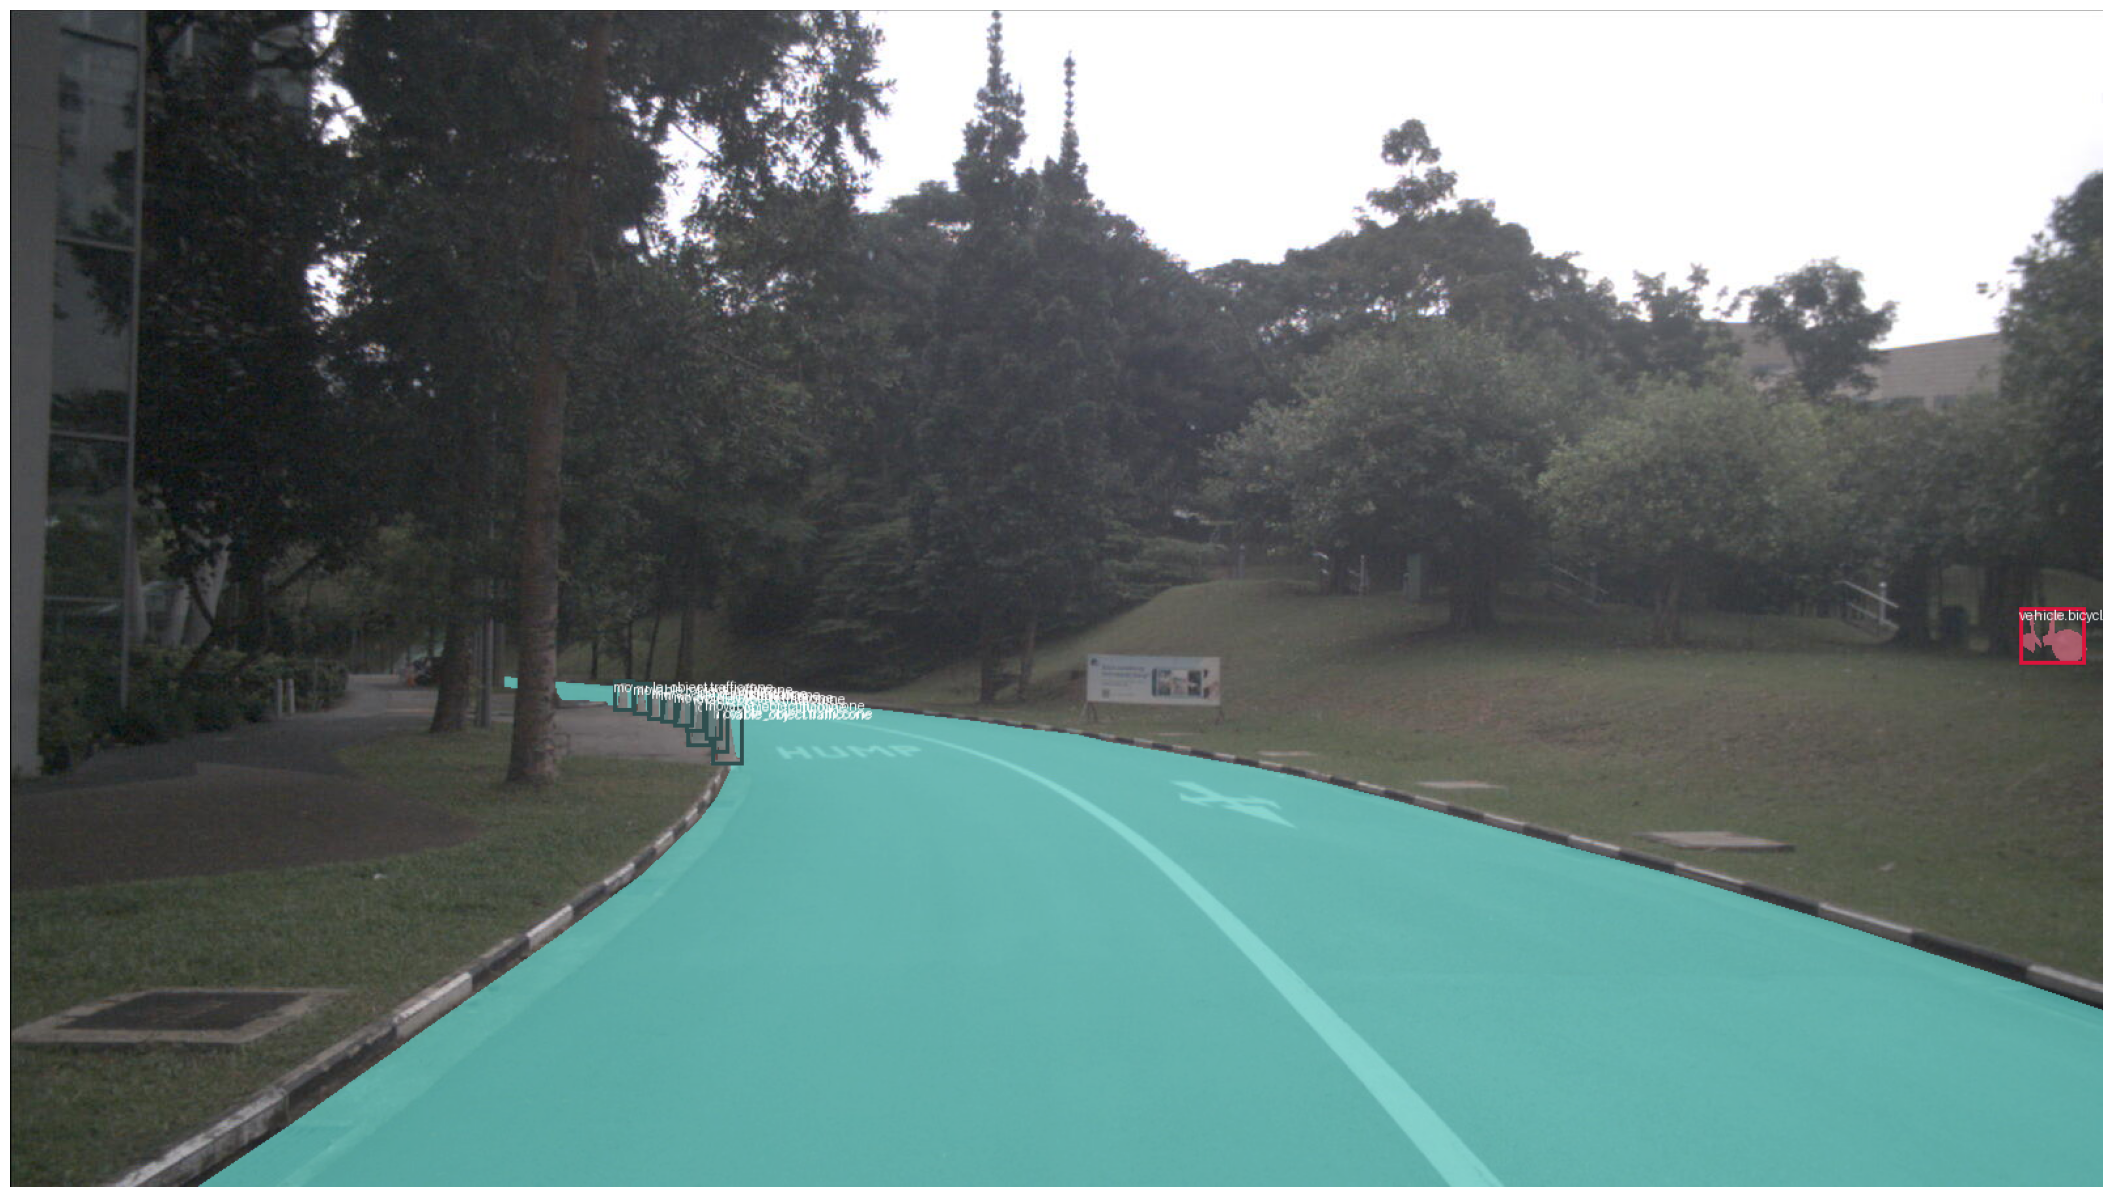

In [8]:
# Visualize the sample
nuim.render_image(detailed_sample['token'], annotation_type='all',
                  with_category=True, with_attributes=True, render_scale=3)

In [9]:
# List the annotations
object_tokens, surface_tokens = nuim.list_anns(sample['token'])

Printing object annotations:
12e786cc743d421b92cf00d15d98ab23 movable_object.trafficcone []
1bf46f0bc102469896dac7ea0dc057b2 movable_object.trafficcone []
26701619ef96471c8100a7682edc43de vehicle.bicycle ['cycle.without_rider']
5a52a16536b84fbbae1131b3e8b9c501 movable_object.trafficcone []
767168cce5934ff883ce1f541ece5af5 movable_object.trafficcone []
874cd90ff1074eaabf37f46d6965befa movable_object.trafficcone []
99977c5b17d947408888bd0427975aa2 movable_object.trafficcone []
a0bf06a36c5449d2ad491ee89b884e0a movable_object.trafficcone []
ae08174835964fd7812032ec5f3d825f movable_object.trafficcone []
e8ccba27b10a4702bda6cf705e2d38ab movable_object.trafficcone []
f75ac3f487554911840fdbb2c482161f movable_object.trafficcone []

Printing surface annotations:
5c6de3604b9c5ef6a147ecbca6002603 flat.driveable_surface


In [10]:
# Access the annotation for the bicycle
ann_1 = nuim.get('object_ann', object_tokens[-1])
ann_1

{'token': 'f75ac3f487554911840fdbb2c482161f',
 'category_token': '85abebdccd4d46c7be428af5a6173947',
 'bbox': [476, 514, 490, 539],
 'mask': {'size': [900, 1600],
  'counts': 'WWxSPTNRbDBPMDEwMEY5RjswMDAwN0k4SDRMMk4wT1VuX24w'},
 'attribute_tokens': [],
 'sample_data_token': '76e6fcd86c964c33b8f4607eb165c960'}

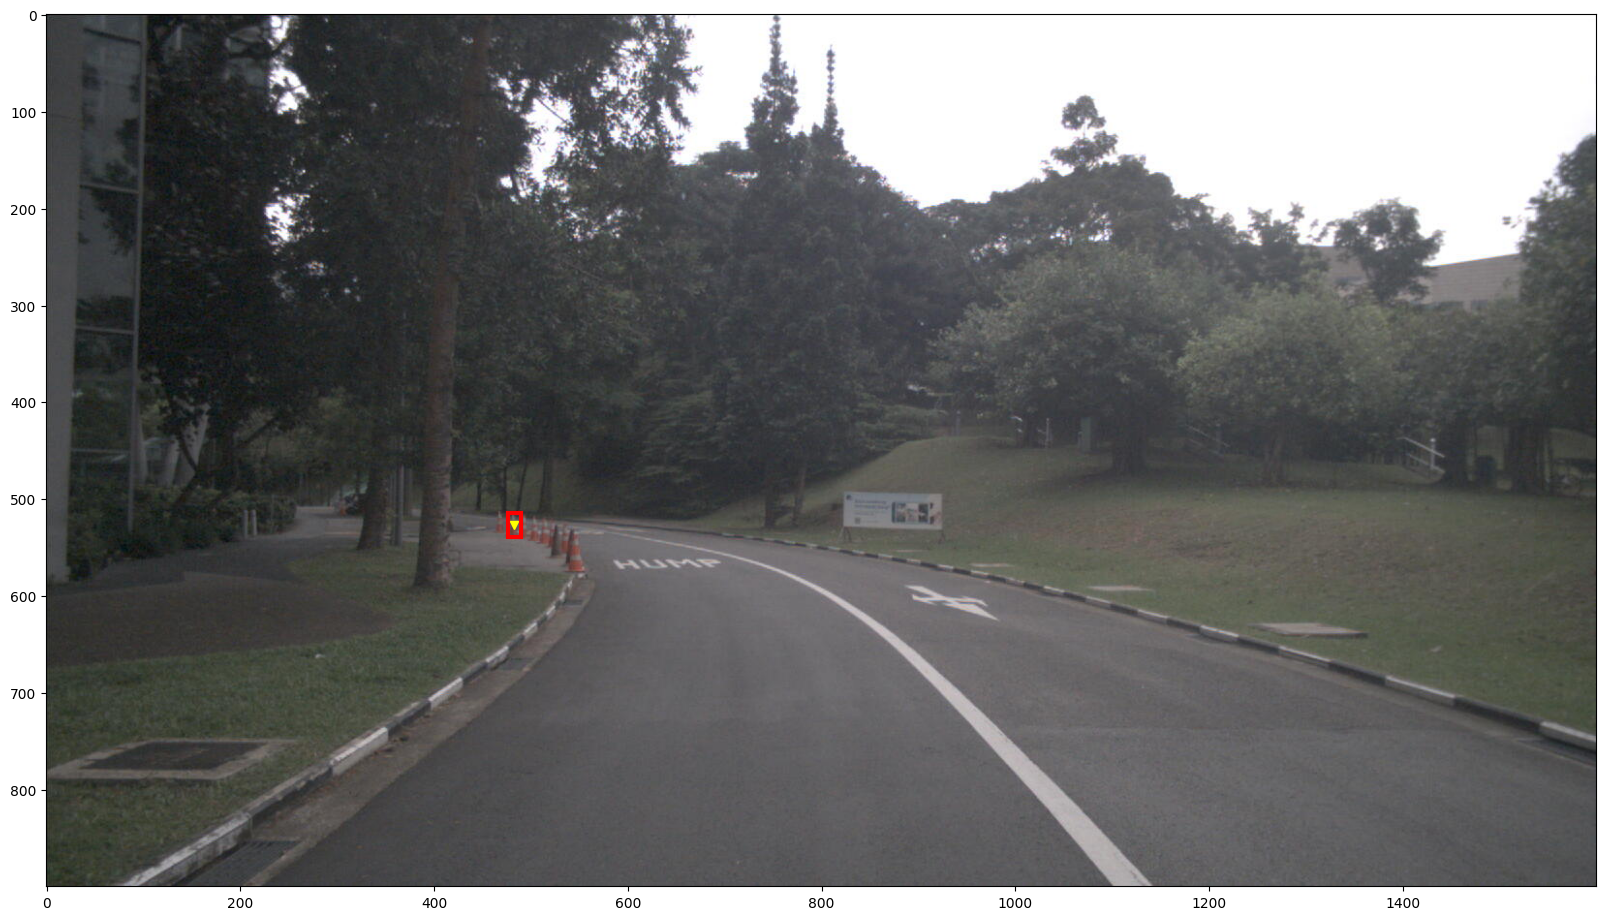

In [11]:
bbox = ann_1['bbox']
bbox_width = bbox[2] - bbox[0]
bbox_height = bbox[3] - bbox[1]
anchor = (bbox[0], bbox[1])
center = ( (bbox[0] + bbox[2]) / 2, (bbox[3] + bbox[1]) /2 )

plt.figure(figsize=(20,20))
img = plt.imread(f"//home/jv/Desktop/data/nuimages-v1.0-all-samples/{detailed_sample['filename']}")

fig = plt.imshow(img)
fig.axes.add_patch(plt.Rectangle(xy=anchor, width=bbox_width, height=bbox_height,
                                 fill=False, color='red', linewidth=3))
plt.plot(center[0], center[1], marker='v', color='yellow')

In [12]:
bbox_width, bbox_height, center

(14, 25, (483.0, 526.5))

In [13]:
# pixel_bounding_boxes = [x_center, y_center, width, height]
# normalized_bounding_boxes = pixel_bb scaled to between 0 and 1
pixel_bb = [center[0], center[1], bbox_width, bbox_height]
normalized_bb = normalize_bb(pixel_bb, IMG_WIDTH, IMG_HEIGHT)
pixel_bb, normalized_bb


([0.301875, 0.585, 0.00875, 0.027777777777777776],
 [0.301875, 0.585, 0.00875, 0.027777777777777776])